Traveling Salesman Problem (TSP)

* Set use_input_txt = 1 if you want to use input from file, or set use_input_txt = 0 to auto generate input data.
* Upload input.txt to current directory at the "Files" bar on the left 
* Click "Runtime" and "Run all" and see the output file BF.txt and BB.txt in current directory





In [13]:
use_input_txt = 0#@param
min_input_size = 5#@param
max_input_size = 15#@param
max_brute_force_input_size = 10#@param
sample_size = 3#@param

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from itertools import permutations, count
from queue import PriorityQueue

In [15]:
def brute_force(cost_matrix):
  n = cost_matrix.shape[0]
  min_cost = np.inf
  min_cost_cycle = []
  for cycle in permutations(range(1, n)):
    # print(cycle)
    cost = cost_matrix[0, cycle[0]] + cost_matrix[cycle[-1], 0]
    for i in range(n-2):
      cost += cost_matrix[cycle[i], cycle[i + 1]]
      # print(cost)
    if cost < min_cost:
      min_cost = cost
      min_cost_cycle = cycle
  return min_cost_cycle, min_cost

In [16]:
def branch_and_bound(cost_matrix):
  # print(cost_matrix)
  n = cost_matrix.shape[0]
  pq = PriorityQueue()
  tiebreaker = count()

  # (lower_bound, index, cost, with arc, cost_matrix)
  pq.put((0, next(tiebreaker), 0, set(), cost_matrix))

  current_best_cycle = None
  upper_bound = np.inf

  while not pq.empty():
    # print("//////////////////////////////////////////")
    # print(pq.queue[0])
    # get smallest lower bound in queue
    lower_bound, index, cost, with_arc, new_cost_matrix = pq.get()
    if lower_bound >= upper_bound:
      # lower bound is higher then the current best solution, discard this child.
      continue
    # print(new_cost_matrix)

    def get_reduce_matrix(new_cost_matrix):
      # calculate cost and reduce matrix
      row_min = np.nan_to_num(new_cost_matrix.min(axis=1), posinf=0)
      # print(row_min)
      reduce_row = new_cost_matrix - row_min[:, np.newaxis]
      # print(reduce_row)
      column_min = np.nan_to_num(reduce_row.min(axis=0), posinf=0)
      # print(column_min)
      reduce_column = reduce_row - column_min
      # print(reduce_column)
      added_cost = row_min.sum() + column_min.sum()
      # print(cost)
      return reduce_column, added_cost
    reduce_column, added_cost = get_reduce_matrix(new_cost_matrix)
    cost += added_cost

    # find best arc to branch
    branch_arc = None
    highest_cost_increment_without_arc = -1
    for arc in np.argwhere(reduce_column == 0):
      # set this arc to inf temporary
      reduce_column[arc[0], arc[1]] = np.inf
      increment = reduce_column[arc[0], :].min() + reduce_column[:, arc[1]].min()
      # print(increment)
      if increment > highest_cost_increment_without_arc:
        highest_cost_increment_without_arc = increment
        branch_arc = tuple(arc)
      # set this arc back to 0
      reduce_column[arc[0], arc[1]] = 0
    # print(highest_cost_increment_without_arc)
    cost_without_arc = cost + highest_cost_increment_without_arc
    # print(branch_arc)
    # print(cost_without_arc)

    with_arc_update = with_arc.copy()
    with_arc_update.add(branch_arc)
    
    if len(with_arc_update) >= n:
      # found one feasible solution
      if cost < upper_bound:
        # current best solution
        upper_bound = cost
        current_best_cycle = with_arc_update
    else:
      # not enough arc to form a solution
      if cost < upper_bound:
        # add with arc to queue
        with_arc_cost_matrix = reduce_column.copy()
        with_arc_cost_matrix[branch_arc[0], :] = np.inf
        with_arc_cost_matrix[:, branch_arc[1]] = np.inf
        with_arc_cost_matrix[branch_arc[1], branch_arc[0]] = np.inf

        # find infeasible arc and set it to inf
        arc_dict = {}
        for from_city, to_city in with_arc_update:
          arc_dict[from_city] = to_city
        # print(arc_dict)
        def find_last_city_in_route(from_city):
          to_city = arc_dict.get(from_city)
          if to_city is None:
            return from_city
          return find_last_city_in_route(to_city)
        if len(with_arc_update) < n-1:
          for from_city in arc_dict:
            last_city = find_last_city_in_route(from_city)
            # print(last_city, from_city)
            with_arc_cost_matrix[last_city, from_city] = np.inf
        
        reduce_matrix, added_cost = get_reduce_matrix(with_arc_cost_matrix)
        # print(added_cost)
        cost_with_arc = cost + added_cost
        if cost_with_arc < upper_bound:
          pq.put((cost_with_arc, next(tiebreaker), cost_with_arc, with_arc_update, reduce_matrix))
      if cost_without_arc < upper_bound:
        # add without arc to queue
        without_arc_cost_matrix = reduce_column.copy()
        without_arc_cost_matrix[branch_arc[0], branch_arc[1]] = np.inf
        pq.put((cost_without_arc, next(tiebreaker), cost, with_arc, without_arc_cost_matrix))
    # print(pq.queue)
    # print(upper_bound)
  
  # get start from 0 cycle
  cycle = []
  arc_dict = {}
  for from_city, to_city in current_best_cycle:
    arc_dict[from_city] = to_city
  # print(arc_dict)
  def get_cycle(from_city):
    to_city = arc_dict[from_city]
    # if len(cycle) >= n:
    #   return
    if to_city != 0:
      cycle.append(to_city)
      get_cycle(to_city)
  get_cycle(0)
  # print(cycle)

  return cycle, upper_bound
# branch_and_bound(cost_matrix)

In [17]:
def print_cycle(cycle, cost, time, file_name):
  if cost == np.inf:
    print("\tno cycle found")
  else:
    solution = '0 - '
    for vertice in cycle:
      solution += '{} - '.format(vertice)
    solution += '0'
    print(f"Solution : {solution}")
    print(f"Cost \t: {cost}")
    print(f"Time \t: {time} s")
    with open(file_name, "w") as text_file:
      print(f"Solution : {solution}", file=text_file)
      print(f"Cost \t: {cost}", file=text_file)
      print(f"Time \t: {time} s", file=text_file)
    

def gen_cost_matrix(n):
  cost_matrix = np.random.randint(1, 100, size=(n, n)).astype(np.float32)
  # some test case
  # cost_matrix[0,:] = np.inf
  # cost_matrix[0,1] = -1
  # cost_matrix = np.ones((n, n))
  np.fill_diagonal(cost_matrix, np.inf)
  cost_matrix[cost_matrix < 0] = np.inf
  return cost_matrix

brute_force_time = []
branch_and_bound_time = []
np.set_printoptions(formatter={'float': '{: 0.0f}'.format})

if use_input_txt:
  brute_force_time = [0]
  input = np.loadtxt('input.txt', skiprows=1)
  # print(input)
  min_input_size = input.shape[0]
  max_input_size = min_input_size

for n in range(min_input_size, max_input_size + 1):
  print("_____________________________________")
  print("n:", n)
  if use_input_txt:
    cost_matrix = input
    np.fill_diagonal(cost_matrix, np.inf)
    cost_matrix[cost_matrix < 0] = np.inf
  else:
    cost_matrix = gen_cost_matrix(n)
  print("cost_matrix:\n", cost_matrix)
  print("")
  print("brute force")
  if n <= max_brute_force_input_size:
    start = timeit.default_timer()
    cycle, brute_force_cost = brute_force(cost_matrix)
    stop = timeit.default_timer()
    if use_input_txt:
      time = stop - start
    else:
      run_time_samples = timeit.repeat(stmt='brute_force(matrix)', setup='from __main__ import gen_cost_matrix, brute_force, n; matrix = gen_cost_matrix(n)', repeat=sample_size, number=1)
      time = np.average(run_time_samples)
      print("run_time_samples: ", run_time_samples)
    print_cycle(cycle, int(brute_force_cost), time, "BF.txt")
    
    brute_force_time.append(time)
  else:
    print(f"n > {max_brute_force_input_size}, too many!")
    time = brute_force_time[-1] * n
    print(f"Time (estimated): {time} s")
    brute_force_time.append(time)
  print("")
  print("branch and bound")
  start = timeit.default_timer()
  cycle, branch_and_bound_cost = branch_and_bound(cost_matrix)
  stop = timeit.default_timer()
  if use_input_txt:
    time = stop - start
  else:
    run_time_samples = timeit.repeat(stmt='branch_and_bound(matrix)', setup='from __main__ import gen_cost_matrix, branch_and_bound, n; matrix = gen_cost_matrix(n)', repeat=sample_size, number=1)
    time = np.average(run_time_samples)
    print("run_time_samples: ", run_time_samples)
  print_cycle(cycle, int(branch_and_bound_cost), time, "BB.txt")
  
  branch_and_bound_time.append(time)
  if n <= max_brute_force_input_size:
    assert brute_force_cost == branch_and_bound_cost, "Cost is different!"

_____________________________________
n: 5
cost_matrix:
 [[ inf  28  42  5  68]
 [ 81  inf  49  1  46]
 [ 54  47  inf  28  95]
 [ 69  1  4  inf  63]
 [ 57  19  73  20  inf]]

brute force
run_time_samples:  [0.00011044800021409173, 0.0001144510001722665, 0.00011534499981280533]
Solution : 0 - 4 - 1 - 3 - 2 - 0
Cost 	: 146
Time 	: 0.00011341466673305452 s

branch and bound
run_time_samples:  [0.0013633879998451448, 0.001921960999879957, 0.001292846000069403]
Solution : 0 - 4 - 1 - 3 - 2 - 0
Cost 	: 146
Time 	: 0.0015260649999315017 s
_____________________________________
n: 6
cost_matrix:
 [[ inf  25  63  58  16  12]
 [ 59  inf  18  6  82  99]
 [ 38  89  inf  60  47  53]
 [ 30  36  7  inf  60  11]
 [ 22  87  81  26  inf  76]
 [ 42  74  55  16  51  inf]]

brute force
run_time_samples:  [0.00033424299999751383, 0.0003190049997101596, 0.0003233899997212575]
Solution : 0 - 5 - 3 - 1 - 2 - 4 - 0
Cost 	: 151
Time 	: 0.00032554599980964366 s

branch and bound
run_time_samples:  [0.0014950629997

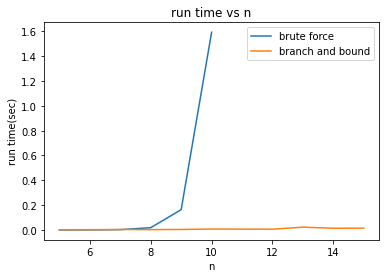

In [18]:
# x = np.arange(min_input_size, max_input_size + 1)
bf_time = brute_force_time[:max_brute_force_input_size - min_input_size + 1]
plt.plot(np.arange(min_input_size, min_input_size + len(bf_time)), bf_time)
plt.plot(np.arange(min_input_size, min_input_size + len(branch_and_bound_time)), branch_and_bound_time)
plt.xlabel('n')
plt.ylabel('run time(sec)')
plt.title('run time vs n')
plt.legend(['brute force', 'branch and bound'])
# plt.xticks(x)
plt.show()